In [1]:
import random
import os
import time
import gc 
from typing import Callable, Dict, List, Optional, Tuple, Type
from pathlib import Path
import enum

import rasterio
from matplotlib import colors, pyplot as plt
from IPython import display
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, RandomSampler
import numpy as np
from scipy.optimize import linear_sum_assignment
import torchvision
from torchvision.ops import box_convert, generalized_box_iou
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms import v2 as T
import timm
from timm.layers import resample_abs_pos_embed 
from tqdm.auto import tqdm
from pprint import pformat
import torchmetrics
from einops import rearrange


from dl_toolbox.datamodules.flair.utils import flair_gather_data
from dl_toolbox.utils import list_of_dicts_to_dict_of_lists, merge_labels, label


/d/pfournie/dl_toolbox/venv38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.trunc_normal_(m.weight, std=0.02)
        if isinstance(m, nn.Linear) and m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 1.0)
        
class DecoderLinear(nn.Module):
    def __init__(self, num_classes, patch_size, embed_dim):
        super().__init__()
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.head = nn.Linear(self.embed_dim, num_classes)
        # self.apply applies to every submodule recursively, typical for init
        self.apply(init_weights)

    def no_weight_decay(self):
        return set()

    def forward(self, x, img_height):
        x = self.head(x) # BxNpatchxEmbedDim -> BxNpatchxNcls
        num_patch_h = img_height//self.patch_size # num_patch_per_axis Np
        # rearrange auto computes h & w from the fixed val h; C-order enum used, see docs
        x = rearrange(x, "b (h w) c -> b c h w", h=num_patch_h) # BxNclsxNpxNp
        return x
    
class SegmenterLinear(nn.Module):
    def __init__(
        self,
        encoder,
        num_classes,
    ):
        super().__init__()
        self.num_classes = num_classes
        self.feature_extractor = timm.create_model(
            encoder, # Name of the pretrained model
            pretrained=True,
            dynamic_img_size=True, # True deals with image sizes != from pretraining, but cause an issue with create_feature_extractor
            fc_norm=False
        )
        self.num_prefix_tokens = self.feature_extractor.num_prefix_tokens
        self.embed_dim = self.feature_extractor.embed_dim
        self.patch_size = self.feature_extractor.patch_embed.patch_size[0]
        self.decoder = DecoderLinear(
            self.num_classes,
            self.patch_size,
            self.embed_dim
        )
        
    def no_weight_decay(self):
        """The names in this module of the parameters we should remove weight decay from must be taken from their names in the timm lib or in the decoder
        """
        def append_prefix_no_weight_decay(prefix, module):
            return set(map(lambda x: prefix + x, module.no_weight_decay()))
        nwd_params = append_prefix_no_weight_decay("feature_extractor.", self.feature_extractor).union(
            append_prefix_no_weight_decay("decoder.", self.decoder)
        )
        return nwd_params
        
    def forward(self, x):
        features = self.feature_extractor.forward_features(x)
        # We ignore non-patch tokens when recovering a segmentation by decoding
        features = features[:,self.num_prefix_tokens:,...]
        H, W = x.size(2), x.size(3)
        masks = self.decoder(features, H)
        masks = nn.functional.interpolate(masks, size=(H, W), mode="bilinear")
        return masks

### Post processing

In [3]:
def build_optimizer(model, lr):
    if hasattr(model, 'no_weight_decay'):
        skip = model.no_weight_decay()
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if "feature_extractor" in name:
            #param.requires_grad = False
            pass
        if param.requires_grad:
            #print(f'{name} in backbone')
            if len(param.shape) == 1 or name.endswith(".bias") or name.split('.')[-1] in skip:
                no_decay.append(param)
            else:
                decay.append(param)
    param_dicts = [
        {"params": no_decay, "weight_decay": 0., "lr": lr},
        {"params": decay, "lr": lr},
    ]
    optimizer = torch.optim.AdamW(param_dicts, weight_decay=0.0001)
    return optimizer

### Dataset & dataloader utils

In [4]:
lut_colors = {
    1: "#db0e9a",
    2: "#938e7b",
    3: "#f80c00",
    4: "#a97101",
    5: "#1553ae",
    6: "#194a26",
    7: "#46e483",
    8: "#f3a60d",
    9: "#660082",
    10: "#55ff00",
    11: "#fff30d",
    12: "#e4df7c",
    13: "#3de6eb",
    14: "#ffffff",
    15: "#8ab3a0",
    16: "#6b714f",
    17: "#c5dc42",
    18: "#9999ff",
    19: "#000000",
}

lut_classes = {
    1: "building",
    2: "pervious",
    3: "impervious",
    4: "bare soil",
    5: "water",
    6: "coniferous",
    7: "deciduous",
    8: "brushwood",
    9: "vineyard",
    10: "herbaceous",
    11: "agricultural",
    12: "plowed land",
    13: "swimmingpool",
    14: "snow",
    15: "clear cut",
    16: "mixed",
    17: "ligneous",
    18: "greenhouse",
    19: "other",
}


def hex2color(hex):
    return tuple([int(z * 255) for z in colors.hex2color(hex)])


all19 = [label(lut_classes[i], hex2color(lut_colors[i]), {i}) for i in range(1, 20)]

main13 = [label("other", (0, 0, 0), {13, 14, 15, 16, 17, 18, 19})] + [
    label(lut_classes[i], hex2color(lut_colors[i]), {i}) for i in range(1, 13)
]

hierarchical6 = [
    label("other", (0,0,0), {19}),
    label("anthropized", hex2color(lut_colors[2]), {1,2,3,13,18}),
    label("natural", hex2color(lut_colors[4]), {4,5,14}),
    label("woody vegetation", hex2color(lut_colors[7]), {6,7,8,15,16,17}),
    label("agricultural", hex2color(lut_colors[11]), {9,11,12}),
    label("herbaceous", hex2color(lut_colors[10]), {10}),
]

class Flair(Dataset):
    
    all_class_lists = classes = enum.Enum(
        "FlairClasses",
        {
            "all19": all19,
            "main13": main13,
            "hierarchical6": hierarchical6
        },
    )


    def __init__(self, imgs, msks, bands, merge, transforms):
        self.imgs = imgs
        self.msks = msks
        self.bands = bands
        self.class_list = self.all_class_lists[merge].value
        self.merges = [list(l.values) for l in self.class_list]
        self.transforms = T.ToDtype(dtype={
            tv_tensors.Image: torch.float32,
            tv_tensors.Mask: torch.int64,
            "others":None
        }, scale=True)
        if transforms is not None:
            self.transforms = T.Compose([self.transforms, transforms])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        
        image_path = self.imgs[idx]
        with rasterio.open(image_path, "r") as file:
            image = file.read(indexes=self.bands)
        image = tv_tensors.Image(torch.from_numpy(image))
        
        target = None
        if self.msks:
            mask_path = self.msks[idx]
            with rasterio.open(mask_path, "r") as file:
                mask = file.read(out_dtype=np.uint8)
            mask = torch.from_numpy(mask)
            mask = merge_labels(mask, self.merges)
            target = tv_tensors.Mask(mask)
            
        image, target = self.transforms(image, target)
        if self.msks:
            target = target.squeeze()
            
        return {'image':image, 'target':target, 'image_path':image_path}

def collate(batch):
    batch = list_of_dicts_to_dict_of_lists(batch)
    batch['image'] = torch.stack(batch['image'])
    batch['target'] = torch.stack(batch['target'])
    return batch

### Seeds

In [5]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### Instanciations

In [6]:
num_classes = 13
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SegmenterLinear(
    num_classes=num_classes,
    encoder='vit_tiny_patch16_224'
)
optimizer = build_optimizer(model, lr=0.0001)
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
nb_tot = sum([int(torch.numel(p)) for p in model.parameters()])
print(f"Training {n_parameters} params out of {nb_tot}")
model.to(device)

criterion = torch.nn.CrossEntropyLoss(
    ignore_index=-1,
    reduction='mean',
    weight=None,
    label_smoothing=0.
)
criterion.to(device)
post_processor = nn.Softmax(dim=1)

Training 5719925 params out of 5719925


In [7]:
tf = T.Compose(
    [
        T.RandomHorizontalFlip(p=0.5),
        T.RandomVerticalFlip(p=0.5),
        T.RandomCrop(size=448, pad_if_needed=True, fill=0),
        T.ToDtype(dtype={
            tv_tensors.Image: torch.float32,
            tv_tensors.Mask: torch.int64,
            "others":None
        }, scale=True),
        T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    ]
)
        
train_domains = [Path("/data/FLAIR_1/train")/d for d in ["D004_2021"]]
imgs, msks, mtds = flair_gather_data(
    train_domains, path_metadata=None, use_metadata=False, test_set=False
)
flair = Flair(imgs, msks, [1,2,3], 'main13', tf)
l, L = int(0.8*len(flair)), len(flair)
val_set = Subset(flair, range(l, L))
train_set = Subset(flair, range(l))

train_dataloader = DataLoader(
    batch_size=4,
    num_workers=4,
    pin_memory=False,
    dataset=train_set,
    sampler=RandomSampler(
        train_set,
    ),
    drop_last=True,
    collate_fn=collate
)

val_dataloader = DataLoader(
    batch_size=4,
    num_workers=4,
    pin_memory=False,
    dataset=val_set,
    shuffle=False,
    drop_last=False,
    collate_fn=collate
)

lr_scheduler = torch.optim.lr_scheduler.ConstantLR(
    optimizer,
    factor=1
)

Processing domains


### Training

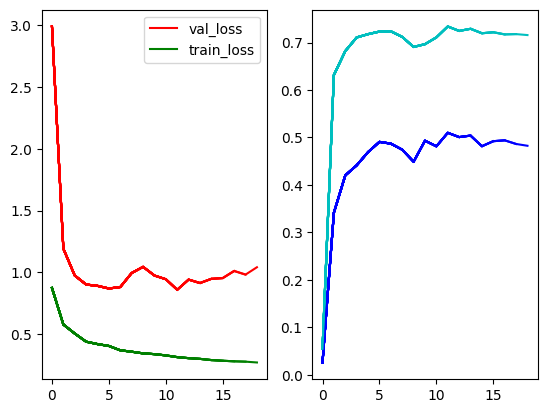

 11%|█████████████▏                                                                                                         | 40/360 [00:03<00:25, 12.38it/s]


KeyboardInterrupt: 

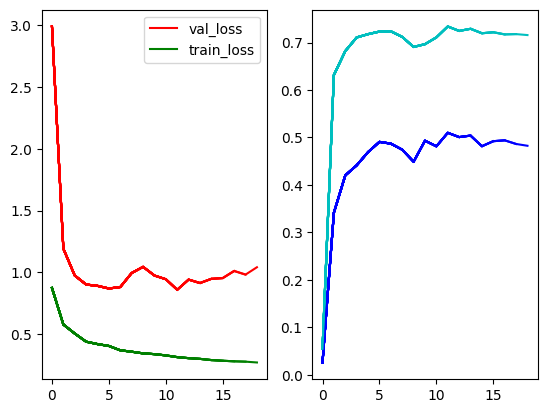

In [9]:
#gc.collect()
#torch.cuda.empty_cache()
#gc.collect()

epochs = []
valid_losses = []
train_losses = []
valid_accs = []
valid_ious = []
metric_args = {
    'task':'multiclass',
    'num_classes':num_classes,
    'ignore_index':0 # should metrics (not loss) ignore an index
}
val_accuracy = torchmetrics.Accuracy(**metric_args)
#val_cm = torchmetrics.ConfusionMatrix(**metric_args, normalize='true')
val_jaccard = torchmetrics.JaccardIndex(**metric_args)

fig, axes = plt.subplots(1,2)
dh = display.display(fig, display_id=True)

for epoch in range(150):
    epochs.append(epoch)
    time_ep = time.time()
    
    # Validating one epoch
    valid_loss = 0
    model.eval()
    criterion.eval()
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            image = batch["image"].to(device)
            targets = batch['target'].to(device)
            pred_logits = model(image)
            loss = criterion(pred_logits, targets)
            probs = post_processor(pred_logits).to('cpu')
            pred_probs, preds = torch.max(probs, dim=1)
            val_accuracy.update(preds, batch['target'])
            val_jaccard.update(preds, batch['target'])
            valid_loss += loss.detach().item()
        valid_loss /= len(val_dataloader)
        val_acc = val_accuracy.compute()
        val_iou = val_jaccard.compute()
        valid_losses.append(valid_loss)
        valid_accs.append(val_acc)
        valid_ious.append(val_iou)
        val_accuracy.reset()
        val_jaccard.reset()
        
    # Training one epoch
    train_loss = 0
    model.train()
    criterion.train()
    for batch in tqdm(train_dataloader):
        image = batch["image"].to(device)
        targets = batch['target'].to(device)
        pred_logits = model(image)
        loss = criterion(pred_logits, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        lr_scheduler.step()
        train_loss += loss.detach().item()
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)
    
    axes[0].plot(epochs, valid_losses, 'r', label='val_loss')
    axes[0].plot(epochs, train_losses, 'g', label='train_loss')
    axes[1].plot(epochs, valid_ious, 'b', label='iou')
    axes[1].plot(epochs, valid_accs, 'c', label='accu')
    if epoch==0: axes[0].legend()
    dh.update(fig)
    time_ep = time.time() - time_ep
    
plt.close()